In [1]:
import os
os.chdir('..')

In [2]:
import numpy as np
import pandas as pd

# Load Data

In [3]:
from enfobench.dataset import DemandDataset

ds = DemandDataset("data")

In [4]:
unique_ids = ds.metadata_subset.list_unique_ids()

In [5]:
len(unique_ids)

100

In [6]:
unique_id = unique_ids[0]
unique_id

'70aec446c47486f3'

In [7]:
target, _, metadata = ds.get_data_by_unique_id(unique_id)

In [8]:
target.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24320 entries, 2012-10-09 08:30:00 to 2014-02-28 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       24317 non-null  float64
dtypes: float64(1)
memory usage: 380.0 KB


# Make external forecasts based on covariates

# Create Dataset

In [9]:
from enfobench.dataset import Dataset

univariate_dataset = Dataset(
    target=target.loc["2012-01-01":"2013-12-31"],
    past_covariates=None,
    future_covariates=None,
    metadata=metadata
)

# Create Model

In [10]:
from enfobench.evaluation import AuthorInfo, ModelInfo, ForecasterType
from enfobench.evaluation.utils import create_forecast_index

class ExampleModel:
    
    def __init__(self, param1: int):
        self.param1 = param1

    def info(self):
        return ModelInfo(
            name="TestModel",
            authors=[
                AuthorInfo(name="Attila Balint")
            ],
            type=ForecasterType.point,
            params={
                "param1": 1,
            },
        )

    def forecast(
        self,
        horizon: int,
        history: pd.DataFrame,
        past_covariates=None,
        future_covariates=None,
        level=None,
        **kwargs,
    ):
        index = create_forecast_index(history, horizon)
        return pd.DataFrame(
            index=index,
            data={
                "yhat": np.full(horizon, fill_value=history["y"].mean()) + self.param1,
            }
        )

In [11]:
model = ExampleModel(1)

# Perform crossvalidation on your model locally

In [12]:
from enfobench.evaluation import cross_validate

crossval_df = cross_validate(
    model, 
    univariate_dataset,
    start_date=pd.Timestamp("2013-07-01T10:00:00"),
    end_date=pd.Timestamp("2013-08-01T00:00:00"),
    horizon=pd.Timedelta("38 hours"), 
    step=pd.Timedelta("1 day"), 
)

100%|██████████| 30/30 [00:00<00:00, 249.37it/s]


In [13]:
crossval_df.head()

,cutoff_date,timestamp,yhat,y
0,2013-07-01 10:00:00,2013-07-01 10:30:00,1.148641,0.050
1,2013-07-01 10:00:00,2013-07-01 11:00:00,1.148641,0.072
2,2013-07-01 10:00:00,2013-07-01 11:30:00,1.148641,0.125
3,2013-07-01 10:00:00,2013-07-01 12:00:00,1.148641,0.081
4,2013-07-01 10:00:00,2013-07-01 12:30:00,1.148641,0.177


# Evaluate metrics

In [14]:
from enfobench.evaluation import evaluate_metrics
from enfobench.evaluation.metrics import mean_absolute_error, mean_bias_error

In [15]:
metrics = evaluate_metrics(
    crossval_df,
    metrics={
        "MAE": mean_absolute_error,
        "MBE": mean_bias_error
    }
)

<Axes: >

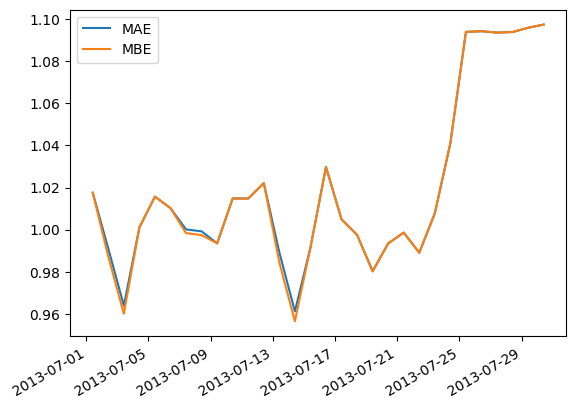

In [16]:
metrics.plot()